# Imports and functions

In [4]:
import os
os.chdir("/app")
print(os.getcwd())

/app


In [5]:
from datetime import datetime
print(datetime.now())
#data preprocessing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import collections
from collections import defaultdict
# NN
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import math
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, auc, accuracy_score
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
from sklearn.impute import SimpleImputer
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients
from tqdm import tqdm


# the full files pathes are here
DATA_PATH_stages="data/kdigo_stages_measured.csv" 
DATA_PATH_labs = "data/labs-kdigo_stages_measured.csv" 
DATA_PATH_vitals = "data/vitals-kdigo_stages_measured.csv" 
DATA_PATH_vents = "data/vents-vasopressor-sedatives-kdigo_stages_measured.csv"
DATA_PATH_detail="data/icustay_detail-kdigo_stages_measured.csv" 
SEPARATOR=";"

2024-05-30 12:32:15.653483


In [6]:
import torch

if (torch.cuda.is_available()):
    print('Training on GPU')
else:
    print('Training on CPU') # On mac book GPU is not possible =() 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Training on GPU


In [7]:
IMPUTE_EACH_ID = False # imputation within each icustay_id with most common value
IMPUTE_COLUMN = False # imputation based on whole column

In [8]:
# Set parameter as constant 

TESTING = False 
TEST_SIZE = 0.05

SPLIT_SIZE = 0.2 
MAX_DAYS = 35

#which classifier to use, only run one classifier at one time 
CLASS1 = True   #AnyAKI
#CLASS2 = False    #ModerateSevereAKI
#CLASS3 = False    #SevereAKI
ALL_STAGES = False # not binary label, each class separately 0,1,2,3
    
MAX_FEATURE_SET = True
#DIAGNOSIS = False

FIRST_TURN_POS = True # creating one label per one ICU stay id

# resampling  and imputing
TIME_SAMPLING = True 
SAMPLING_INTERVAL = '6H'
RESAMPLE_LIMIT = 16 # 4 days*6h interval
MOST_COMMON = False #resampling with most common
# if MOST_COMMON is not applied,sampling with different strategies per kind of variable, 
# numeric variables use mean value, categorical variables use max value

IMPUTE_METHOD = 'most_frequent' 
FILL_VALUE = 0 #fill missing value and ragged part of 3d array

#Age constraints: adults
ADULTS_MIN_AGE = 18
ADULTS_MAX_AGE = 120

NORMALIZATION = 'min-max' 

CAPPING_THRESHOLD_UPPER = 0.99
CAPPING_THRESHOLD_LOWER = 0.01

# How much time the prediction should occur (hours)
HOURS_AHEAD = 48

NORM_TYPE = 'min_max'

RANDOM = 42

#set changable info corresponding to each classifier as variables

min_set =  ["icustay_id", "charttime", "creat", "uo_rt_6hr", "uo_rt_12hr", "uo_rt_24hr", "aki_stage"]

max_set = ['icustay_id', 'charttime', 'aki_stage', 'hadm_id','aniongap_avg', 'bicarbonate_avg', 
           'bun_avg','chloride_avg', 'creat', 'diasbp_mean', 'glucose_avg', 'heartrate_mean',
           'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 'resprate_mean','sodium_avg', 'spo2_mean', 'sysbp_mean', 
           'uo_rt_12hr', 'uo_rt_24hr','uo_rt_6hr', 'wbc_avg', 'sedative', 'vasopressor', 'vent', 'age', 'F','M', 
           'asian', 'black', 'hispanic', 'native', 'other', 'unknown','white', 'ELECTIVE', 'EMERGENCY', 'URGENT']

# LSTM
batch_size = 5

# naming model and plot
classifier_name = "None vs. Any AKI"    ###change every time #Moderate vs. Severe #None vs. Any #Others vs. Severe
plot_name = "adult_AnyAKI_LR"    ###change every time

In [9]:
# Some functions used later

def cap_data(df):
    print("Capping between the {} and {} quantile".format(CAPPING_THRESHOLD_LOWER, CAPPING_THRESHOLD_UPPER))
    cap_mask = df.columns.difference(['icustay_id', 'charttime', 'aki_stage'])
    df[cap_mask] = df[cap_mask].clip(df[cap_mask].quantile(CAPPING_THRESHOLD_LOWER),
                                     df[cap_mask].quantile(CAPPING_THRESHOLD_UPPER),
                                     axis=1)

    return df
 
    
def normalise_data(df, norm_mask):
    print("Normalizing in [0,1] with {} normalization".format(NORMALIZATION))
    
    df[norm_mask] = (df[norm_mask] - df[norm_mask].min()) / (df[norm_mask].max() - df[norm_mask].min())
    
    return df


# impute missing value in resampleing data with most common based on each id
def fast_mode(df, key_cols, value_col):
    """ Calculate a column mode, by group, ignoring null values. 
    
    key_cols : list of str - Columns to groupby for calculation of mode.
    value_col : str - Column for which to calculate the mode. 

    Return
    pandas.DataFrame
        One row for the mode of value_col per key_cols group. If ties, returns the one which is sorted first. """
    return (df.groupby(key_cols + [value_col]).size() 
              .to_frame('counts').reset_index() 
              .sort_values('counts', ascending=False) 
              .drop_duplicates(subset=key_cols)).drop('counts',axis=1)


#get max shape of 3d array
def get_dimensions(array, level=0):   
    yield level, len(array)
    try:
        for row in array:
            yield from get_dimensions(row, level + 1)
    except TypeError: #not an iterable
        pass

def get_max_shape(array):
    dimensions = defaultdict(int)
    for level, length in get_dimensions(array):
        dimensions[level] = max(dimensions[level], length)
    return [value for _, value in sorted(dimensions.items())]

#pad the ragged 3d array to rectangular shape based on max size
def iterate_nested_array(array, index=()):
    try:
        for idx, row in enumerate(array):
            yield from iterate_nested_array(row, (*index, idx)) 
    except TypeError: # final level            
        yield (*index, slice(len(array))), array # think of the types

def pad(array, fill_value):
    dimensions = get_max_shape(array)
    result = np.full(dimensions, fill_value, dtype = np.float64)  
    for index, value in iterate_nested_array(array):
        result[index] = value 
    return result

def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)

    # In sklearn.calibration.calibration_curve,
    # the last value in the array is always 0.
    binids = np.digitize(y_prob, bins) - 1

    return np.bincount(binids, minlength=len(bins))

def missing_bin(bin_array):
    midpoint = " "    
    if bin_array[0]==0:
        midpoint = "5%, "
    if bin_array[1]==0:
        midpoint = midpoint + "15%, "
    if bin_array[2]==0:
        midpoint = midpoint + "25%, "
    if bin_array[3]==0:
        midpoint = midpoint + "35%, " 
    if bin_array[4]==0:
        midpoint = midpoint + "45%, "
    if bin_array[5]==0:
        midpoint = midpoint + "55%, "
    if bin_array[6]==0:
        midpoint = midpoint + "65%, "
    if bin_array[7]==0:
        midpoint = midpoint + "75%, "
    if bin_array[8]==0:
        midpoint = midpoint + "85%, "
    if bin_array[9]==0:
        midpoint = midpoint + "95%, "
    return "The missing bins have midpoint values of "+ str(midpoint)

In [10]:
data_path = "data_theirs"

## Data Loading & Preprocessing

In [ ]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
# print column names
print(X.columns)
# print number of rows and columns
print(X.shape)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])

#merge rows if they have exact timestamp within same icustay_id AL : it substitutes missing values with zero
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


In [ ]:
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
                   'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
                   'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])

if  MAX_FEATURE_SET:
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)
    dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
                        'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
                        "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)    
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    # AL drop those where all columns are nan (empty rows)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
     

In [ ]:
print(datetime.now())
# Labs file: instead of min and max their avg
counter = 0
col1 = 4
col2 = 5
null_l = [] # no null values in those that are different
changed = 0 # 4316 records changed to avg

while counter < 11:
    row = 0
# find where min and max are different and save their row indices 
    while row < len(dataset_labs):
        a = dataset_labs.iloc[row,col1]
        b = dataset_labs.iloc[row,col2]
        if a==b or (np.isnan(a) and np.isnan(b)):
            pass
        elif a!=b:
            changed +=1
            avg = (a+b)/2
            dataset_labs.iloc[row,col1] = avg
            if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
                null_l.append(row)
        else:
            print(a)
            print(b)
        row +=1       
    # delete the redundant column max, update counters
    dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
    counter = counter+1
    col1 = col1+1
    col2 = col2+1

dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
                        'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
                        'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
if len(null_l)>0:
    print("null values encountered")
print(datetime.now())

In [ ]:
print("Merge creatinine and glucose.")
# merge creatinine from labs and set with labels
creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
creat_l = creat_l.dropna(subset=['creatinine_avg'])
creat = X[['icustay_id','charttime', 'creat']].copy()
creat = creat.dropna(subset=['creat'])
creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
creat = creat._append(creat_l, ignore_index=True)
creat.drop_duplicates(inplace = True)
#delete old columns
dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
X.drop(["creat"], axis = 1, inplace = True)
#merge new column
X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)

if MAX_FEATURE_SET:
    # merge glucose from vitals and labs
    glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
    glucose_v = glucose_v.dropna(subset=['glucose_mean'])
    glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
    glucose = glucose.dropna(subset=['glucose_avg'])
    glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
    glucose = glucose._append(glucose_v, ignore_index=True)
    glucose.drop_duplicates(inplace = True)
    #delete old columns
    dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
    dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
    #merge new column
    dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
    
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing time dependent data") 
print("Removing patients under the min age")
old_length = len(X)
dataset_detail = dataset_detail.loc[dataset_detail['admission_age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)
new_length = len(X)

# print out number of patients removed
print("Number of patients removed: ", old_length - new_length)


In [ ]:
print(old_length)
print(new_length)

In [ ]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list

id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)

long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list

new_length = len(X)
print(new_length)

In [ ]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)

new_length = len(X)
print(new_length)


In [ ]:
# For testing purpose, use small amount of data first
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= TEST_SIZE, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

## Resampling , imputing

In [ ]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean() 
    X_label = X['aki_stage'].max()
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
#Label forward fill
X['aki_stage'] = X['aki_stage'].ffill(limit=RESAMPLE_LIMIT)

new_length = len(X) 
print(new_length)

In [ ]:
print("Imputation.")
# do imputation of label with zero if there are still missing values
X['aki_stage'] = X['aki_stage'].fillna(0)

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    column_name = list(X.columns)
    column_name.remove(column_name[0]) 
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])       

# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    cols = list(X.columns)
    cols = cols[2:23]
    X[cols]=imp.fit_transform(X[cols])  

# If no imputation method selected or only impute each id, for the remaining nan impute direclty with FILL_VALUE
X = X.fillna(FILL_VALUE) 

In [ ]:
# print out the number of columns of X
print(len(X.columns))

In [ ]:
# more comfortable to review in this order
try:
    cols = ['icustay_id', 'charttime','aki_stage','hadm_id','aniongap_avg','bicarbonate_avg', 'bun_avg','chloride_avg',
            'creat','diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg','hemoglobin_avg', 
            'potassium_avg', 'resprate_mean', 'sodium_avg','spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 
            'uo_rt_24hr', 'uo_rt_6hr','wbc_avg', 'sedative', 'vasopressor', 'vent' ]
    X = X[cols]
    print("success")
except:
    try:
        cols = ['icustay_id', 'charttime','aki_stage','creat','uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr']
        X = X[cols]
    except:
        print("error")

In [ ]:
# save the preprocessed data to csv
X.to_csv('data/preprocessed_data.csv', index=False)

In [15]:
# load the preprocessed data
X = pd.read_csv('data/data/X1.csv')

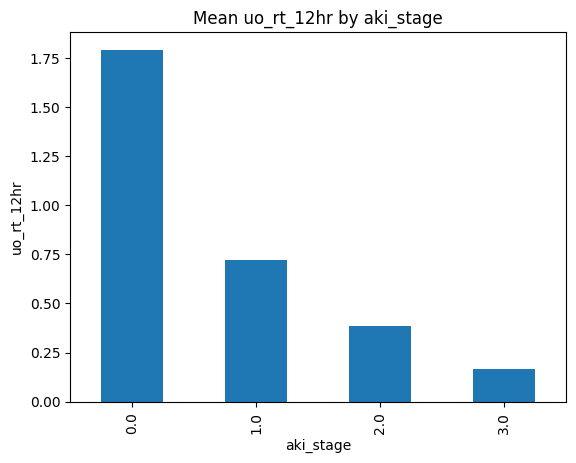

In [17]:
col = "uo_rt_12hr"

plt.figure()
X.groupby('aki_stage')[col].mean().plot(kind='bar')
plt.ylabel(col)
plt.title(f'Mean {col} by aki_stage')
plt.savefig(f'data/analysis/{col}_by_aki_stage.png')

In [ ]:
# print headers of X
print(X.columns)

In [ ]:
print("binarise labels")
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

## SHIFTING labels

In [ ]:
#print("Shifting the labels 48 h") # by 8 position : 6h sampling*8=48h and ffil 8 newly empty ones
X['aki_stage'] = X.groupby('icustay_id')['aki_stage'].shift(-(HOURS_AHEAD // int(SAMPLING_INTERVAL[:-1])))
X = X.dropna(subset=['aki_stage'])
X['icustay_id'].nunique()

## Add categorical features (details)

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing not time dependent data")
if MAX_FEATURE_SET:
    #extract datasets based on id_list
    dataset_detail = dataset_detail.loc[dataset_detail['icustay_id'].isin(id_list)]
    #sort by ascending order
    dataset_detail = dataset_detail.sort_values(by=['icustay_id'])
    subject_id = dataset_detail["subject_id"].unique()
    #transfrom categorical data to binary form
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('gender')))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop("ethnicity_grouped")))
    # dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('admission_type')))
    dataset_detail = dataset_detail.drop(['subject_id', 'hadm_id'], axis=1)
    X =  pd.merge(X, dataset_detail, on = ["icustay_id"], how= "left", copy = False) 
    numeric_feat.append('admission_age')

In [ ]:
feature_names =['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']



In [ ]:
X.columns

In [ ]:
print(len(X))

## Data Loading & Preprocessing

In [ ]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
# print column names
print(X.columns)
# print number of rows and columns
print(X.shape)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])

#merge rows if they have exact timestamp within same icustay_id AL : it substitutes missing values with zero
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


In [ ]:
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
                   'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
                   'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])

if  MAX_FEATURE_SET:
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)
    dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
                        'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
                        "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)    
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    # AL drop those where all columns are nan (empty rows)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
     

In [ ]:
print(datetime.now())
# Labs file: instead of min and max their avg
counter = 0
col1 = 4
col2 = 5
null_l = [] # no null values in those that are different
changed = 0 # 4316 records changed to avg

while counter < 11:
    row = 0
# find where min and max are different and save their row indices 
    while row < len(dataset_labs):
        a = dataset_labs.iloc[row,col1]
        b = dataset_labs.iloc[row,col2]
        if a==b or (np.isnan(a) and np.isnan(b)):
            pass
        elif a!=b:
            changed +=1
            avg = (a+b)/2
            dataset_labs.iloc[row,col1] = avg
            if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
                null_l.append(row)
        else:
            print(a)
            print(b)
        row +=1       
    # delete the redundant column max, update counters
    dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
    counter = counter+1
    col1 = col1+1
    col2 = col2+1

dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
                        'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
                        'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
if len(null_l)>0:
    print("null values encountered")
print(datetime.now())

In [ ]:
print("Merge creatinine and glucose.")
# merge creatinine from labs and set with labels
creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
creat_l = creat_l.dropna(subset=['creatinine_avg'])
creat = X[['icustay_id','charttime', 'creat']].copy()
creat = creat.dropna(subset=['creat'])
creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
creat = creat._append(creat_l, ignore_index=True)
creat.drop_duplicates(inplace = True)
#delete old columns
dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
X.drop(["creat"], axis = 1, inplace = True)
#merge new column
X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)

if MAX_FEATURE_SET:
    # merge glucose from vitals and labs
    glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
    glucose_v = glucose_v.dropna(subset=['glucose_mean'])
    glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
    glucose = glucose.dropna(subset=['glucose_avg'])
    glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
    glucose = glucose._append(glucose_v, ignore_index=True)
    glucose.drop_duplicates(inplace = True)
    #delete old columns
    dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
    dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
    #merge new column
    dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
    
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing time dependent data") 
print("Removing patients under the min age")
old_length = len(X)
dataset_detail = dataset_detail.loc[dataset_detail['admission_age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)
new_length = len(X)

# print out number of patients removed
print("Number of patients removed: ", old_length - new_length)


In [ ]:
print(old_length)
print(new_length)

In [ ]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list

id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)

long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list

new_length = len(X)
print(new_length)

In [ ]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)

new_length = len(X)
print(new_length)


In [ ]:
# For testing purpose, use small amount of data first
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= TEST_SIZE, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

## Resampling , imputing

In [ ]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean() 
    X_label = X['aki_stage'].max()
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
#Label forward fill
X['aki_stage'] = X['aki_stage'].ffill(limit=RESAMPLE_LIMIT)

new_length = len(X) 
print(new_length)

In [ ]:
print("Imputation.")
# do imputation of label with zero if there are still missing values
X['aki_stage'] = X['aki_stage'].fillna(0)

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    column_name = list(X.columns)
    column_name.remove(column_name[0]) 
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])       

# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    cols = list(X.columns)
    cols = cols[2:23]
    X[cols]=imp.fit_transform(X[cols])  

# If no imputation method selected or only impute each id, for the remaining nan impute direclty with FILL_VALUE
X = X.fillna(FILL_VALUE) 

In [ ]:
# print out the number of columns of X
print(len(X.columns))

In [ ]:
# more comfortable to review in this order
try:
    cols = ['icustay_id', 'charttime','aki_stage','hadm_id','aniongap_avg','bicarbonate_avg', 'bun_avg','chloride_avg',
            'creat','diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg','hemoglobin_avg', 
            'potassium_avg', 'resprate_mean', 'sodium_avg','spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 
            'uo_rt_24hr', 'uo_rt_6hr','wbc_avg', 'sedative', 'vasopressor', 'vent' ]
    X = X[cols]
    print("success")
except:
    try:
        cols = ['icustay_id', 'charttime','aki_stage','creat','uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr']
        X = X[cols]
    except:
        print("error")

In [ ]:
# save the preprocessed data to csv
X.to_csv('data/preprocessed_data.csv', index=False)

In [ ]:
# print headers of X
print(X.columns)

In [ ]:
print("binarise labels")
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

## SHIFTING labels

In [ ]:
#print("Shifting the labels 48 h") # by 8 position : 6h sampling*8=48h and ffil 8 newly empty ones
X['aki_stage'] = X.groupby('icustay_id')['aki_stage'].shift(-(HOURS_AHEAD // int(SAMPLING_INTERVAL[:-1])))
X = X.dropna(subset=['aki_stage'])
X['icustay_id'].nunique()

## Add categorical features (details)

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing not time dependent data")
if MAX_FEATURE_SET:
    #extract datasets based on id_list
    dataset_detail = dataset_detail.loc[dataset_detail['icustay_id'].isin(id_list)]
    #sort by ascending order
    dataset_detail = dataset_detail.sort_values(by=['icustay_id'])
    subject_id = dataset_detail["subject_id"].unique()
    #transfrom categorical data to binary form
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('gender')))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop("ethnicity_grouped")))
    # dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('admission_type')))
    dataset_detail = dataset_detail.drop(['subject_id', 'hadm_id'], axis=1)
    X =  pd.merge(X, dataset_detail, on = ["icustay_id"], how= "left", copy = False) 
    numeric_feat.append('admission_age')

In [ ]:
feature_names =['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']



In [ ]:
X.columns

In [ ]:
print(len(X))

## Save the data

In [ ]:
# save X
X.to_csv(os.path.join(data_path, 'preprocessed_data.csv'), index=False)

# Our data

In [ ]:
data_path = "data_ours"

## Data Loading & Preprocessing

In [ ]:
print("read csv files")
#reading csv files
X = pd.read_csv(DATA_PATH_stages, sep= SEPARATOR)
# print column names
print(X.columns)
# print number of rows and columns
print(X.shape)
X.drop(["aki_stage_creat", "aki_stage_uo"], axis = 1, inplace = True)
#remove totally empty rows 
X = X.dropna(how = 'all', subset = ['creat','uo_rt_6hr','uo_rt_12hr','uo_rt_24hr','aki_stage'])
print("convert charttime to timestamp")
X['charttime'] = pd.to_datetime(X['charttime'])

#merge rows if they have exact timestamp within same icustay_id AL : it substitutes missing values with zero
#X = X.groupby(['icustay_id', 'charttime']).sum().reset_index(['icustay_id', 'charttime'])

dataset_detail = pd.read_csv(DATA_PATH_detail, sep= SEPARATOR)  #age constraint
dataset_detail.drop(['dod', 'admittime','dischtime', 'los_hospital','ethnicity','hospital_expire_flag', 'hospstay_seq',
       'first_hosp_stay', 'intime', 'outtime', 'los_icu', 'icustay_seq','first_icu_stay'], axis = 1, inplace = True)


In [ ]:
dataset_labs = pd.read_csv(DATA_PATH_labs, sep= SEPARATOR) # 'bands lactate platelet ptt inr pt
# dataset_labs.drop(['albumin_min', 'albumin_max','bilirubin_min', 'bilirubin_max','bands_min', 'bands_max',
#                    'lactate_min', 'lactate_max','platelet_min', 'platelet_max','ptt_min', 'ptt_max', 
#                    'inr_min', 'inr_max', 'pt_min', 'pt_max'], axis = 1, inplace = True)
dataset_labs = dataset_labs.dropna(subset=['charttime'])
dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
dataset_labs['charttime'] = pd.to_datetime(dataset_labs['charttime'])
dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'])

if  MAX_FEATURE_SET:
    dataset_vitals = pd.read_csv(DATA_PATH_vitals, sep= SEPARATOR)  
    dataset_vents = pd.read_csv(DATA_PATH_vents , sep= SEPARATOR)
    #dataset_icd = pd.read_csv(DATA_PATH_icd, sep= SEPARATOR)
    # dataset_vitals.drop(["heartrate_min", "heartrate_max","sysbp_min", "sysbp_max","diasbp_min", "diasbp_max",
    #                     'meanbp_min','meanbp_max', 'meanbp_mean','tempc_min', 'tempc_max', 'tempc_mean',
    #                     "resprate_min", "resprate_max", "spo2_min", "spo2_max", "glucose_min", "glucose_max"], axis = 1, inplace = True)    
    print("convert charttime to timestamp")
    dataset_vitals['charttime'] = pd.to_datetime(dataset_vitals['charttime'])
    dataset_vents['charttime'] = pd.to_datetime(dataset_vents['charttime'])
    dataset_vitals = dataset_vitals.sort_values(by=['icustay_id', 'charttime'])
    dataset_vents = dataset_vents.sort_values(by=['icustay_id', 'charttime'])
    # AL drop those where all columns are nan (empty rows)
    dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')   
     

In [ ]:
# print(datetime.now())
# # Labs file: instead of min and max their avg
# counter = 0
# col1 = 4
# col2 = 5
# null_l = [] # no null values in those that are different
# changed = 0 # 4316 records changed to avg

# while counter < 11:
#     row = 0
# # find where min and max are different and save their row indices 
#     while row < len(dataset_labs):
#         a = dataset_labs.iloc[row,col1]
#         b = dataset_labs.iloc[row,col2]
#         if a==b or (np.isnan(a) and np.isnan(b)):
#             pass
#         elif a!=b:
#             changed +=1
#             avg = (a+b)/2
#             dataset_labs.iloc[row,col1] = avg
#             if (np.isnan(a) and ~np.isnan(b)) or (np.isnan(b) and ~np.isnan(a)):
#                 null_l.append(row)
#         else:
#             print(a)
#             print(b)
#         row +=1       
#     # delete the redundant column max, update counters
#     dataset_labs.drop(dataset_labs.columns[col2], axis=1, inplace = True)
#     counter = counter+1
#     col1 = col1+1
#     col2 = col2+1

# dataset_labs.columns = ['subject_id','hadm_id', 'icustay_id', 'charttime', 'aniongap_avg', 'bicarbonate_avg', 
#                         'creatinine_avg', 'chloride_avg', 'glucose_avg', 'hematocrit_avg','hemoglobin_avg',
#                         'potassium_avg', 'sodium_avg', 'bun_avg', 'wbc_avg']
# if len(null_l)>0:
#     print("null values encountered")
# print(datetime.now())

In [ ]:
# print("Merge creatinine and glucose.")
# # merge creatinine from labs and set with labels
# creat_l = dataset_labs[['icustay_id','charttime','creatinine_avg']].copy()
# creat_l = creat_l.dropna(subset=['creatinine_avg'])
# creat = X[['icustay_id','charttime', 'creat']].copy()
# creat = creat.dropna(subset=['creat'])
# creat_l = creat_l.rename(columns={"creatinine_avg": "creat"})
# creat = creat._append(creat_l, ignore_index=True)
# creat.drop_duplicates(inplace = True)
# #delete old columns
# dataset_labs.drop(["creatinine_avg"], axis = 1, inplace = True)
# dataset_labs = dataset_labs.dropna(subset=dataset_labs.columns[4:], how='all')
# X.drop(["creat"], axis = 1, inplace = True)
# #merge new column
# X = pd.merge(X, creat, on = ["icustay_id", "charttime"], sort = True, how= "outer", copy = False)

# if MAX_FEATURE_SET:
#     # merge glucose from vitals and labs
#     glucose_v = dataset_vitals[['subject_id','hadm_id','icustay_id','charttime', 'glucose_mean']].copy()
#     glucose_v = glucose_v.dropna(subset=['glucose_mean'])
#     glucose = dataset_labs[['subject_id','hadm_id','icustay_id','charttime', 'glucose_avg']].copy()
#     glucose = glucose.dropna(subset=['glucose_avg'])
#     glucose_v = glucose_v.rename(columns={"glucose_mean": "glucose_avg"})
#     glucose = glucose._append(glucose_v, ignore_index=True)
#     glucose.drop_duplicates(inplace = True)
#     #delete old columns
#     dataset_labs.drop(["glucose_avg"], axis = 1, inplace = True)
#     dataset_vitals.drop(["glucose_mean"], axis = 1, inplace = True)
#     dataset_vitals = dataset_vitals.dropna(subset=dataset_vitals.columns[4:], how='all')
#     #merge new column
#     dataset_labs = pd.merge(dataset_labs, glucose, on = ['subject_id','hadm_id','icustay_id','charttime',], sort = True, how= "outer", copy = False)
    
# dataset_labs = dataset_labs.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
# X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
def merge_in_chunks(X, dataset, on, chunk_size):
    num_chunks = len(dataset) // chunk_size
    for i in range(num_chunks):
        chunk = dataset[i*chunk_size:(i+1)*chunk_size]
        yield pd.merge(X, chunk, on=on, how="outer", copy=False)

chunk_size = 5000

if MAX_FEATURE_SET:
    X_generator = merge_in_chunks(X, dataset_labs, ["icustay_id", "charttime"], chunk_size)
    X = pd.concat(X_generator, ignore_index=True)

    X_generator = merge_in_chunks(X, dataset_vitals, ["icustay_id", "charttime","subject_id", "hadm_id"], chunk_size)
    X = pd.concat(X_generator, ignore_index=True)

    X_generator = merge_in_chunks(X, dataset_vents, ["icustay_id", "charttime"], chunk_size)
    X = pd.concat(X_generator, ignore_index=True)

    X.drop(["subject_id"], axis = 1, inplace = True)

In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    X = pd.merge(X, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    X = pd.merge(X, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    X.drop(["subject_id"], axis = 1, inplace = True) 


In [ ]:
print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    # Split X into two halves
    X1 = X.iloc[:len(X)//2]
    X2 = X.iloc[len(X)//2:]
    print("Split X into two halves")

    # Merge each half with the other DataFrames
    X1 = pd.merge(X1, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    print("Merged X1 with labs")
    X1 = pd.merge(X1, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    print("Merged X1 with vitals")
    X1 = pd.merge(X1, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    print("Merged X1 with vents")
    X1.drop(["subject_id"], axis = 1, inplace = True)

    # Write X1 to disk and delete it from memory
    X1.to_csv('X1.csv')
    del X1
    
    print("Wrote X1 to disk")

    X2 = pd.merge(X2, dataset_labs, on = ["icustay_id", "charttime"], how= "outer", copy = False)
    print("Merged X2 with labs")
    X2 = pd.merge(X2, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer", copy = False)
    print("Merged X2 with vitals")
    X2 = pd.merge(X2, dataset_vents, on = ["icustay_id", "charttime"], how= "outer", copy = False) 
    print("Merged X2 with vents")
    X2.drop(["subject_id"], axis = 1, inplace = True)

    # Write X2 to disk and delete it from memory
    X2.to_csv('X2.csv')
    del X2

    print("Wrote X2 to disk")
    
    # Read X1 and X2 from disk and concatenate the results
    X1 = pd.read_csv('X1.csv')
    print("Read X1 from disk")
    X2 = pd.read_csv('X2.csv')
    print("Read X2 from disk")
    X = pd.concat([X1, X2])
    print("Concatenated X1 and X2")

    # Delete X1 and X2 from memory
    del X1
    del X2

In [ ]:
import dask.dataframe as dd

print("Merging labs, vitals and vents files")
if MAX_FEATURE_SET:
    # Split X into two halves
    X1 = X.iloc[:len(X)//2]
    X2 = X.iloc[len(X)//2:]
    print("Split X into two halves")

    # Convert X1 and X2 to Dask DataFrames
    X1 = dd.from_pandas(X1, npartitions=2)
    X2 = dd.from_pandas(X2, npartitions=2)

    # Merge each half with the other DataFrames
    X1 = dd.merge(X1, dataset_labs, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X1 with labs")
    X1 = dd.merge(X1, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer")
    print("Merged X1 with vitals")
    X1 = dd.merge(X1, dataset_vents, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X1 with vents")
    X1 = X1.drop(["subject_id"], axis = 1)

    X2 = dd.merge(X2, dataset_labs, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X2 with labs")
    X2 = dd.merge(X2, dataset_vitals, on = ["icustay_id", "charttime","subject_id", "hadm_id"], how= "outer")
    print("Merged X2 with vitals")
    X2 = dd.merge(X2, dataset_vents, on = ["icustay_id", "charttime"], how= "outer")
    print("Merged X2 with vents")
    X2 = X2.drop(["subject_id"], axis = 1)

    # Concatenate X1 and X2
    X = dd.concat([X1, X2])
    print("Concatenated X1 and X2")

In [ ]:
# read X1 from disk
X = pd.read_csv('X1.csv')

In [ ]:
# Drop the 'charttime' column
X_numeric = X.drop('charttime', axis=1)

# Calculate the correlation with 'aki_stage'
correlation_to_aki_stage = X_numeric.corrwith(X_numeric['aki_stage'])

# Plotting the correlations
plt.figure(figsize=(10, 8))
correlation_to_aki_stage.sort_values().plot(kind='bar')
plt.title('Correlation of Attributes with aki_stage')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('data/analysis/correlation_to_aki_stage_X1.png')

In [ ]:
# Correlation between numeric variables
corr = X_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('data/analysis/correlation_matrix_X1.png')

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing time dependent data") 
print("Removing patients under the min age")
old_length = len(X)
dataset_detail = dataset_detail.loc[dataset_detail['admission_age'] >= ADULTS_MIN_AGE]
adults_icustay_id_list = dataset_detail['icustay_id'].unique()
X = X[X.icustay_id.isin(adults_icustay_id_list)].sort_values(by=['icustay_id'], ignore_index = True)
X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
adults_icustay_id_list = np.sort(adults_icustay_id_list)
new_length = len(X)

# print out number of patients removed
print("Number of patients removed: ", old_length - new_length)


In [ ]:
print(old_length)
print(new_length)

In [ ]:
print("drop icustay_id with time span less than 48hrs")
def more_than_HOURS_ahead(adults_icustay_id_list, X):
    drop_list = []
    los_list = [] # calculating LOS ICU based on charttime
    long_stays_id = [] # LOS longer than MAX DAYS days
    last_charttime_list = []
    seq_length = X.groupby(['icustay_id'],as_index=False).size()
    id_count = 0
    first_row_index = 0

    while id_count < len(adults_icustay_id_list):
        icustay_id = adults_icustay_id_list[id_count]
        last_row_index = first_row_index + seq_length.iloc[id_count,1]-1
        first_time = X.iat[first_row_index, X.columns.get_loc('charttime')]
        last_time = X.iat[last_row_index, X.columns.get_loc('charttime')]
        los = round(float((last_time - first_time).total_seconds()/60/60/24),4) # in days
        if los < HOURS_AHEAD/24:
            drop_list.append(icustay_id)
        else:
            los_list.append(los)
            if los > MAX_DAYS:
                long_stays_id.append(icustay_id)
                last_charttime_list.append(last_time)
        # udpate for the next icustay_id
        first_row_index = last_row_index+1
        id_count +=1
    if len(long_stays_id) != len(last_charttime_list):
        print('ERROR')
    print("%d long stays" % len(long_stays_id))
    # drop all the rows with the saved icustay_id
    print("there are %d id-s shorter than 48 hours" % len(drop_list))
    X = X[~X.icustay_id.isin(drop_list)]
    id_list = X['icustay_id'].unique()
    X = X.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
    
    return id_list, X, long_stays_id,last_charttime_list

id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(adults_icustay_id_list, X)

long = pd.DataFrame()
long['icustay_id']  = long_stays_id
long['last_time']  = last_charttime_list

new_length = len(X)
print(new_length)

In [ ]:
# deleting rows that are not within MAX_DAYS (35) period
i = 0 # long df index
drop_long_time = []
    
while i < len(long_stays_id):
    j = 0
    all_rows = X.index[X['icustay_id'] == long.loc[i,'icustay_id']].tolist()
    while j < len(all_rows):
        time = X.iat[all_rows[j], X.columns.get_loc('charttime')]
        # if keep last MAX_DAYS 
        if (long.loc[i,'last_time'] - time).total_seconds() > MAX_DAYS*24*60*60:
            drop_long_time.append(all_rows[j])
            j +=1
        else:
            break
    i +=1       
X.drop(X.index[drop_long_time], inplace=True) 

# checking for 48h min length again
id_list, X, long_stays_id,last_charttime_list  = more_than_HOURS_ahead(id_list, X)
dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'], ignore_index = True)

new_length = len(X)
print(new_length)


In [ ]:
# For testing purpose, use small amount of data first
if TESTING:
    rest, id_list = train_test_split(id_list, test_size= TEST_SIZE, random_state=42)
    X = X[X.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])
    dataset_detail = dataset_detail[dataset_detail.icustay_id.isin(id_list)].sort_values(by=['icustay_id'])

## Resampling , imputing

In [ ]:
if (TIME_SAMPLING and MOST_COMMON):
    print("resampling: MOST_COMMON")
    # Resample the data using assigned interval,mode() for most common
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL).mode().reset_index()
elif TIME_SAMPLING:
    print("resampling: MEAN & ZERO")
    # Sampling with different strategies per kind of variable
    label = ['aki_stage']
    skip = ['icustay_id', 'charttime', 'aki_stage']
    if MAX_FEATURE_SET:
        discrete_feat = ['sedative', 'vasopressor', 'vent', 'hadm_id']
        skip.extend(discrete_feat)    
    # all features that are not in skip are numeric
    numeric_feat = list(X.columns.difference(skip))
    
    # Applying aggregation to features depending on their type
    X = X.set_index('charttime').groupby('icustay_id').resample(SAMPLING_INTERVAL)
    if MAX_FEATURE_SET:
        X_discrete = X[discrete_feat].max().fillna(FILL_VALUE).astype(np.int64)
    X_numeric = X[numeric_feat].mean() 
    X_label = X['aki_stage'].max()
    print("Merging sampled features")
    try:
        X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
    except:
        X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
#Label forward fill
X['aki_stage'] = X['aki_stage'].ffill(limit=RESAMPLE_LIMIT)

new_length = len(X) 
print(new_length)

: 

In [ ]:
print("Imputation.")
# do imputation of label with zero if there are still missing values
X['aki_stage'] = X['aki_stage'].fillna(0)

# using most common within each icustay_id
if IMPUTE_EACH_ID:
    column_name = list(X.columns)
    column_name.remove(column_name[0]) 
    for feature in column_name:
        X.loc[X[feature].isnull(), feature] = X.icustay_id.map(fast_mode(X, ['icustay_id'], feature).set_index('icustay_id')[feature])       

# imputation based on whole column
if IMPUTE_COLUMN:
    imp = SimpleImputer(missing_values=np.nan, strategy= IMPUTE_METHOD)
    cols = list(X.columns)
    cols = cols[2:23]
    X[cols]=imp.fit_transform(X[cols])  

# If no imputation method selected or only impute each id, for the remaining nan impute direclty with FILL_VALUE
X = X.fillna(FILL_VALUE) 

In [ ]:
# print out the number of columns of X
print(len(X.columns))

In [ ]:
# more comfortable to review in this order
try:
    cols = ['icustay_id', 'charttime','aki_stage','hadm_id','aniongap_avg','bicarbonate_avg', 'bun_avg','chloride_avg',
            'creat','diasbp_mean', 'glucose_avg', 'heartrate_mean', 'hematocrit_avg','hemoglobin_avg', 
            'potassium_avg', 'resprate_mean', 'sodium_avg','spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 
            'uo_rt_24hr', 'uo_rt_6hr','wbc_avg', 'sedative', 'vasopressor', 'vent' ]
    X = X[cols]
    print("success")
except:
    try:
        cols = ['icustay_id', 'charttime','aki_stage','creat','uo_rt_12hr', 'uo_rt_24hr', 'uo_rt_6hr']
        X = X[cols]
    except:
        print("error")

In [ ]:
# save the preprocessed data to csv
X.to_csv('data/preprocessed_data.csv', index=False)

In [ ]:
# print headers of X
print(X.columns)

In [ ]:
print("binarise labels")
if ALL_STAGES:
    pass
elif CLASS1:
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS2:
    X.loc[X['aki_stage'] < 2, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 1, 'aki_stage'] = 1
elif CLASS3:
    X.loc[X['aki_stage'] < 3, 'aki_stage'] = 0
    X.loc[X['aki_stage'] > 2, 'aki_stage'] = 1

## SHIFTING labels

In [ ]:
#print("Shifting the labels 48 h") # by 8 position : 6h sampling*8=48h and ffil 8 newly empty ones
X['aki_stage'] = X.groupby('icustay_id')['aki_stage'].shift(-(HOURS_AHEAD // int(SAMPLING_INTERVAL[:-1])))
X = X.dropna(subset=['aki_stage'])
X['icustay_id'].nunique()

## Add categorical features (details)

In [ ]:
print(dataset_detail.columns)

In [ ]:
print("start preprocessing not time dependent data")
if MAX_FEATURE_SET:
    #extract datasets based on id_list
    dataset_detail = dataset_detail.loc[dataset_detail['icustay_id'].isin(id_list)]
    #sort by ascending order
    dataset_detail = dataset_detail.sort_values(by=['icustay_id'])
    subject_id = dataset_detail["subject_id"].unique()
    #transfrom categorical data to binary form
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('gender')))
    dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop("ethnicity_grouped")))
    # dataset_detail = dataset_detail.join(pd.get_dummies(dataset_detail.pop('admission_type')))
    dataset_detail = dataset_detail.drop(['subject_id', 'hadm_id'], axis=1)
    X =  pd.merge(X, dataset_detail, on = ["icustay_id"], how= "left", copy = False) 
    numeric_feat.append('admission_age')

In [ ]:
feature_names =['Anion gap', 'Bicarbonate', 'Blood Urea Nitrogen', 'Chloride', 'Creatinine', 'Diastolic BP', 'Glucose', 'Heart rate', 
            'Hematocrit', 'Hemoglobin', 'Potassium', 'Respiratory rate', 'Sodium', 'Oxygen saturation', 'Systolic BP', 'Urine output 12h', 'Urine output 24h', 'Urine output 6h',
            'White cell count', 'Sedative', 'Vasopressor', 'Ventilation', 'Age', 'Female gender', 'Male gender', 'Asian ethnicity', 'Black ethnicity', 'Hispanic ethnicity', 'Native american', 
            'Other ethnicity', 'Ethnicity unknown', 'White ethnicity', 'Elective admission', 'Emergency admission', 'Urgent admission']



In [ ]:
X.columns

In [ ]:
print(len(X))

## Save the data

In [ ]:
# save X
X.to_csv(os.path.join(data_path, 'preprocessed_data.csv'), index=False)

# Data Exploration

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create the directory if it doesn't exist
os.makedirs('data/analysis', exist_ok=True)

# Summary statistics
X.describe().to_csv('data/analysis/summary_statistics.csv')

# Distribution of numeric values
numeric_cols = ['aniongap_avg', 'bicarbonate_avg', 'bun_avg', 'chloride_avg', 'creat', 'diasbp_mean',
                'glucose_avg', 'heartrate_mean', 'hematocrit_avg', 'hemoglobin_avg', 'potassium_avg', 
                'resprate_mean', 'sodium_avg', 'spo2_mean', 'sysbp_mean', 'uo_rt_12hr', 'uo_rt_24hr', 
                'uo_rt_6hr', 'wbc_avg', 'admission_age']
for col in numeric_cols:
    plt.figure()
    sns.histplot(X[col].dropna())
    plt.title(f'Distribution of {col}')
    plt.savefig(f'data/analysis/{col}_distribution.png')

# Distribution of categorical values
categorical_cols = ['aki_stage', 'sedative', 'vasopressor', 'vent', 'F', 'M', 'asian', 'black', 'hispanic', 'native', 'other', 'unknown', 'white']
for col in categorical_cols:
    plt.figure()
    sns.countplot(x=col, data=X)
    plt.title(f'Distribution of {col}')
    plt.savefig(f'data/analysis/{col}_count.png')

# Correlation between numeric variables
corr = X[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.savefig('data/analysis/correlation_matrix.png')

correlation_to_aki_stage = X.corrwith(X['aki_stage'])

# Plotting the correlations
plt.figure(figsize=(10, 8))
correlation_to_aki_stage.sort_values().plot(kind='bar')
plt.title('Correlation of Attributes with aki_stage')
plt.ylabel('Correlation')
plt.tight_layout()
plt.savefig('data/analysis/correlation_to_aki_stage_binarised.png')

# Correlation between 'aki_stage' and other attributes
for col in numeric_cols:
    plt.figure()
    X.groupby('aki_stage')[col].mean().plot(kind='bar')
    plt.ylabel(col)
    plt.title(f'Mean {col} by aki_stage')
    plt.savefig(f'data/analysis/{col}_by_aki_stage.png')

In [ ]:
# print max values of colums "admission_age"
print(X['admission_age'].max())

In [ ]:
# X = cap_data(X)
X = normalise_data(X, numeric_feat)

In [ ]:
X = X.sort_values(by=['icustay_id', 'charttime'])
seq_lengths = X.groupby(['icustay_id'],as_index=False).size().sort_values(by = ['size'],ascending=False)
sequence_length = seq_lengths.max() # the longest sequence per icustay-id
print(sequence_length)

In [ ]:
#AL re-write as try except to make it work as hadm_id is not used if only one csv file is used and none are merged
try:
    X.drop(['hadm_id'], axis=1, inplace = True)
except:
    pass

In [ ]:
features = X.shape[1]-3

In [ ]:
print("divide dataset into train, test and validation sets")
id_train, id_test_val = train_test_split(id_list, test_size = SPLIT_SIZE, random_state = 42) # train set is 80%)
print("train is %d" % len(id_train))
# remaining 20% split in halves as test and validation 10% and 10%
id_valid, id_test = train_test_split(id_test_val, test_size = 0.5, random_state = 42) # test 10% valid 10%
print("val and test are %d" %len(id_test))


In [ ]:
train = X[X.icustay_id.isin(id_train)].sort_values(by=['icustay_id'])
test = X[X.icustay_id.isin(id_test)].sort_values(by=['icustay_id'], ignore_index = True) 
validation = X[X.icustay_id.isin(id_valid)].sort_values(by=['icustay_id']) 

test = test.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
train = train.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)
validation = validation.sort_values(by=['icustay_id', 'charttime'], ignore_index = True)

In [ ]:
test['icustay_id'].nunique()

In [ ]:
test_seq = test.groupby(['icustay_id'],as_index=False).size()